# 3. Working with data

* [**3.0 Preamble**](#preamble)
* [**3.1 What data looks like**](#data)
* [**3.2 Dataframes**](#dataframe)
* [**3.3 Selecting from a dataframe**](#select)
* [**3.4 Tabulation and indexed arrays**](#table)
* [**3.5 Joining dataframes**](#join)
* [**3.6 Extended example**](#example) &hellip;&hellip; [categorical](#categorical), [numerical](#numerical), [date/time](#datetime) variables, [clever joins](#wrangling), [fancy plots](#plotting)

<div class="alert alert-warning">
**Goal of this notebook:**
<ul style="margin-top: 0px">
<li>Get used to the standard ways of thinking about data, _data frames_ and _indexed arrays_</li>
<li>Learn how to use the <a href="http://pandas.pydata.org/">Pandas</a> library to handle data</li>
<li>See some more advanced plotting with <a href="https://matplotlib.org/">matplotlib</a></li>
</ul>

There are some exercises in this section of notes. They are for you to get practice on: they are optional, and do not contribute to your final grade. You can check your answers to labelled exercises as described in [&sect;0.3](0.%20About%20this%20course.ipynb#grader) using `section='notes3'`.

# 3.0 Preamble<span id="preamble"><span>

At the top of almost every piece of data-oriented scientific computing work, we'll import these standard modules.

In [3]:
# Import modules, and give them short aliases so we can write e.g. np.foo rather than numpy.foo
import numpy as np
import pandas
import matplotlib
import matplotlib.pyplot as plt
# The next line is a piece of magic, to let plots appear in our Jupyter notebooks
%matplotlib inline 

The running example for this section is a dataset of stop-and-search records, [made available](https://data.police.uk/data/) by the UK home office. As it's a moderate-sized file (172MB) I like to download it to disk, so it's fast to reread it each time I restart the notebook. Here's how we can fetch a file from a url, using the Unix command-line tool `wget`. (The exclamation mark is called a [_Jupyter magic_](http://ipython.readthedocs.io/en/stable/interactive/magics.html), and it means "Treat this line as though it were executed at the command prompt". In IB _Unix Tools_ you'll learn more about the Unix command line.)

In [4]:
# Execute a unix command to download a file (if it's not already downloaded), and show download progress
import os.path
if os.path.exists('stop-and-search.csv'):
    print("file already downloaded")
else:
    !wget "https://teachingfiles.blob.core.windows.net/founds/stop-and-search.csv"

--2017-12-11 18:53:15--  https://teachingfiles.blob.core.windows.net/founds/stop-and-search.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving teachingfiles.blob.core.windows.net... 52.174.224.26
Connecting to teachingfiles.blob.core.windows.net|52.174.224.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179821411 (171M) [text/csv]
Saving to: ‘stop-and-search.csv’

stop-and-search.csv 100%[===================>] 171.49M  1.41MB/s    in 2m 21s  

2017-12-11 18:55:37 (1.22 MB/s) - ‘stop-and-search.csv’ saved [179821411/179821411]



# 3.1 What data looks like<span id="data"></span>

We almost always work with data in the form of a spreadsheet-like table, referred to as a _dataframe_. Here's how to load a dataframe from a file and inspect it. (This dataframe will be used as a running example in the rest of &sect;3.)

In [5]:
# Import a dataframe using the pandas library
stopsearch = pandas.read_csv('stop-and-search.csv')

# How many rows are there?
print("This dataset has", len(stopsearch), "rows")
# Display the first 3 rows. iloc[:3] means "select the first three rows"
stopsearch.iloc[:3]

This dataset has 808101 rows


,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,year,month,police_force
0,Person search,2014-07-31T23:20:00+00:00,NaN,NaN,50.938234,-1.388559,Male,25-34,Asian or Asian British - Pakistani (A2),Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Nothing found - no further action,NaN,NaN,2014,8,hampshire
1,Person search,2014-07-31T23:30:00+00:00,NaN,NaN,50.912978,-1.431990,Male,over 34,White - White British (W1),White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Suspect summonsed to court,NaN,NaN,2014,8,hampshire
2,Person search,2014-07-31T23:45:00+00:00,NaN,NaN,51.005612,-1.497576,Male,10-17,White - White British (W1),White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Nothing found - no further action,NaN,NaN,2014,8,hampshire


A dataframe is a collection of named columns. Each column has the same length, and all entries in a column have the same type, though different columns may have different types. If you have taken IA/IB _Databases_, you'll see that dataframes are similar to tables in a relational database. There are some differences:

* Scientific data is best thought of as logs of observations. Observed facts cannot be unobserved, so UPDATE and DELETE database operations are irrelevant, as are questions about database consistency.
* A dataframe has ordered rows, like an array, whereas a database table is unordered.
* We are often given messy badly structured data to work with; and we often create dataframes on the fly, work with them for a little while, then discard them. There is rarely a phase of entity-relationship modeling: instead we learn how to think about a dataset by working with it.

In Python, there are several choices about how to represent dataframes. A simple choice is as a dictionary of lists:
```
mydata = {'police_force': ['hampshire', 'hampshire', 'hampshire', ...],
          'Age range': ['25-34', 'over 34', '10-17', ...],
          'year': [2014, 2014, 2014, ...],
          ...}
```
We won't use this representation. Instead we'll use the [Pandas](http://pandas.pydata.org/) library, designed specifically for working with data. It has several benefits:

* Data import and export has lots of fiddly corner cases. Even printing a dataframe takes a surprisingly large amount of code to do well.
* For fast numerical computation and concise code, `numpy` is best as we saw in [&sect;2](2.%20Numerical%20computation.ipynb). Pandas stores dataframe columns as `numpy` vectors.
* Some simple operations, like selecting a subset of rows, takes a lot of boilerplate code if implemented in pure Python. Much better to use a Pandas dataframe, which lets us write e.g. `stopsearch.iloc[:3]` to select some entries from each column, without our even having to think about iterating over columns.

It has the disadvantage of being yet another library to learn. It also has some idiosyncratic notation for indexing, which in my experience can lead to
rather cryptic error messages when plotting, and which will be discussed in [&sect;3.2](#indexing). It has poor support for missing values in data, which it inherits from `numpy`. Despite these problems, it's the best choice at this stage in Python's evolution.

# 3.2 Importing, exporting, and creating dataframes<span id="dataframe"></span>

It's very easy to import data from a simple comma-separated value (CSV) file. A CSV file looks like this:

>```
>"Sepal.Length","Sepal.Width","Petal.Length","Petal.Width","Species"
>5.1,3.5,1.4,0.2,"setosa"
>4.9,3,1.4,0.2,"setosa"
>4.7,3.2,1.3,0.2,"setosa"
>4.6,3.1,1.5,0.2,"setosa"
>5,3.6,1.4,0.2,"setosa"
>```

i.e. a header line, then one line per row of the data frame, with values separated by commas.
We've already seen how to import a CSV, using [`pandas.read_csv`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html).
If your file is nearly a CSV but has some quirks such as comments or a missing header row, experiment with the 55 options in [`pandas.read_csv`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html).
We can use the same function to read CSV files from remote urls (though if you're using Azure Notebooks, be aware that Azure only permits you to connect to Azure web servers.)

In [4]:
import urllib.request  # standard Python library for url requests
iris = pandas.read_csv(urllib.request.urlopen('https://teachingfiles.blob.core.windows.net/scicomp/iris.csv'))

In my experience, around 70% of the time you spend working with data will be fighting to import it and clean it up. See
[&sect;A3](A3.%20Data%20import%20and%20cleanup.ipynb) for a collection of recipes for web scraping, reading from a database, and parsing log files.

To write a CSV file,
```
iris.to_csv('iris.csv', index=False)
```
If you're running this notebook with Azure Notebooks, you would then use the `Data | Download` menu to download the file from Azure Notebooks to your local machine.

To create a dataframe from scratch, pass in a dictionary of columns. Python dictionaries are unordered, so you can optionally specify the column order you want with the `columns` argument.

In [5]:
iris = pandas.DataFrame({'species': ['setosa', 'virginica', 'virginica', 'setosa', 'versicolor'],
                         'Petal.length': [1.0, 5.0, 5.8, 1.7, 4.2],
                         'Petal.width': [0.2, 1.9, 1.6, 0.5, 1.2]},
                        columns = ['species', 'Petal.length', 'Petal.width'])

Or you can create a dataframe from a list of tuples. Now the `columns` argument is needed to say what the column names are.

In [6]:
iris = pandas.DataFrame([('setosa', 1.0, 0.2), ('virginica', 5.0, 1.9), ('virginica', 5.8, 1.6),
                         ('setosa', 1.7, 0.5), ('versicolor', 4.2, 1.2)],
                        columns = ['species', 'Petal.length', 'Petal.width'])

A dataframe behaves like a dictionary of vectors, and you can add and remove columns using the same syntax you'd use for dictionaries. When you add new columns, Pandas converts them to `numpy` vectors for you, so you can use the usual `numpy` operations. (The columns aren't actually plain `numpy` vectors, as [&sect;3.3](#indexing) explains, and the difference will bite you whenever you try to subset a column.)

In [7]:
iris.keys()                                                # what column names are present?
iris['Sepal.length'] = [4.6, 6.3, 7.2, 5.1, 5.7]           # add a column
if 'Petal.width' in iris: del iris['Petal.width']          # delete a column (if present)
iris['P/S'] = iris['Petal.length'] / iris['Sepal.length']  # vectorized whole-column operation
iris

,species,Petal.length,Sepal.length,P/S
0,setosa,1.0,4.6,0.217391
1,virginica,5.0,6.3,0.793651
2,virginica,5.8,7.2,0.805556
3,setosa,1.7,5.1,0.333333
4,versicolor,4.2,5.7,0.736842


To modify an entry in a dataframe, I prefer to "think vectorized" and replace the entire column, e.g.
```
iris['Petal.length'] = np.where(np.arange(5)==0, 100, iris['Petal.length'])
```
If we modify only some of the rows of a dataframe, then (depending how exactly we do it) Pandas will tell us off, warning us that the operation may be inefficient.

In [16]:
iris['Petal.length'][0] = 200

/home/djw/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# 3.3 Selecting from a dataframe<span id="select"></span>
Dataframes have a triple identity: part array, part database table, part dictionary. Because of this, there are several ways to select subsets of rows and columns.

Selecting columns is easy. We've already seen how to select one column. To select several columns,

In [8]:
# Select three columns, and print out the first 5 rows of the resulting dataframe
stopsearch[['Date', 'Object of search', 'Legislation']].iloc[:5]

,Date,Object of search,Legislation
0,2014-07-31T23:20:00+00:00,Controlled drugs,Misuse of Drugs Act 1971 (section 23)
1,2014-07-31T23:30:00+00:00,Controlled drugs,Misuse of Drugs Act 1971 (section 23)
2,2014-07-31T23:45:00+00:00,Controlled drugs,Misuse of Drugs Act 1971 (section 23)
3,2014-08-01T00:40:00+00:00,Stolen goods,Police and Criminal Evidence Act 1984 (section 1)
4,2014-08-01T02:05:00+00:00,Article for use in theft,Police and Criminal Evidence Act 1984 (section 1)


To select subsets of rows by row number use `.iloc[row_indexes]`. This can take any slice or list of integers.

In [ ]:
stopsearch.iloc[:3]       # the first 3 rows; stopsearch[:3] is an abbreviation for this
stopsearch.iloc[[0,3,5]]  # select several rows, by providing a list of row numbers
stopsearch.iloc[[5]]      # select a dataframe object consisting of just one row
stopsearch.iloc[:3][['Date', 'Object of search']]  #first a row selector, then a column selector

To select subsets of rows by a boolean vector use `.loc[rows_indicator]` where `rows_indicator` is a boolean vector as long as the dataframe. You can optionally also specify a list of columns to select.

In [ ]:
wantcols = ['Date', 'Object of search', 'Outcome']
wantrows = stopsearch['police_force'] == 'cambridgeshire'  # a boolean vector
stopsearch.loc[wantrows, wantcols][:3]

There is a third way to select rows from a dataframe, which in my experience is the source of endless confusion: selecting by row index.

When you see a Pandas dataframe printed out, there is a column at the left printed in bold. These aren't row numbers, they are _row indexes_, which behave like the keys in a dictionary. In all the examples we've seen so far the indexes happen to be numbers, but they could be any other Python object. Pandas remembers row indexes, even when you pull out a single column, and it always tries to match indexes. This is usually not what we want.
I recommend that you 
**always use <code style="background-color:red; color:white">.values</code> when you are working with subsets of rows.**
This gives you the actual `numpy` vector behind the column, not the confusing Pandas vector-plus-index object.

We won't be using row indexes in this course, but it's worth knowing they exist so you can understand the cryptic errors and error messages you will undoubtedly come across.

In [ ]:
df = pandas.DataFrame({'x': [3,3,4,8,2,7,6]})

# This looks like it's adding [3,3,4,8] and [8,2,7,6] -- but it's not!
df['x'][:4] + df['x'][-4:]

# This is the way to do it
df['x'][:4].values + df['x'][-4:].values

# 3.4 Tabulations and indexed arrays<span id="table"></span>
The pattern behind much data processing is split-apply-combine-join: split your data into pieces, apply a transformation to each piece, combine the pieces, and join results from different datasets together. We could code this explicitly with a `for` loop, but it would involve lots of boilerplate code &mdash; and I hope you have been persuaded by [&sect;2](2.%20Numerical%20computation.ipynb) that `for` loops are considered harmful. Instead, let's see how to do it with Pandas.

The following line of code performs a cross-tabulation: it splits the data into a separate dataframe for each combination of officer-defined ethnicity and gender, applies the `len` function to each sub-dataframe to get the number of rows it contains, and combines the results into a single indexed object. 

In [18]:
x = stopsearch.groupby(['Officer-defined ethnicity', 'Gender']).apply(len)
x

Officer-defined ethnicity  Gender
Asian                      Female      2230
                           Male       72458
                           Other         85
Black                      Female      7497
                           Male      151988
                           Other        189
Mixed                      Female        22
                           Male         327
Other                      Female       974
                           Male       16221
                           Other        147
White                      Female     47947
                           Male      414428
                           Other        986
dtype: int64

* If you have a function you want to apply to only one column, use `dataframe.groupby(...)[colname].apply(fun)`.
* For this course, we will only `apply` functions that return simple Python values. It's [more complicated](http://pandas.pydata.org/pandas-docs/stable/groupby.html) to apply functions that return dataframes or Pandas columns or indexed arrays.

The groupby/apply command has produced an _indexed array_.
An indexed array is a cross between a normal numpy array and a dataframe. We access elements and sub-arrays by dimension, like a numpy array &mdash; but we use `.loc[]` and the indexes aren't integer positions, they're values from the underlying column. Also, the array might be 'incomplete', as in the example above which has no entry for `['Mixed','Other']`.

In [ ]:
x.loc['Asian']               # select a sub-array indexed just by Gender
x.loc[:, 'Other']            # select a sub-array indexed by Ethnicity (all levels)
x.loc[['Mixed','White']]     # select a sub-array indexed by Ethnicity (two levels) and Gender (all levels)
# The index labels can be accessed with  x.index.levels[0].values and x.index.levels[1].values

To pretty-print an indexed array, use [`unstack()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.unstack.html). It will by default fill in any missing values with `NaN` (not a number), and you can override this with `fill_value`.

In [74]:
x[['Mixed','White']].unstack(fill_value=0)

Gender,Female,Male,Other
Officer-defined ethnicity,,,
Mixed,22,327,0
White,47947,414428,986


When you first start working with data, I recommend you do all your calculations on dataframes rather than indexed arrays. If you want to do calculations on an indexed array, first turn it into a dataframe. There are two ways to do this, depending on whether you want it _long form_ or _wide form_.

In [75]:
# Convert an indexed array into a long-form dataframe 
x[['Mixed','White']].reset_index()

,Officer-defined ethnicity,Gender,0
0,Mixed,Female,22
1,Mixed,Male,327
2,White,Female,47947
3,White,Male,414428
4,White,Other,986


In [76]:
# Convert an indexed array into a wide-form dataframe. See note below about rename_axis
x[['Mixed','White']].unstack(fill_value=0).reset_index().rename_axis(None, axis=1)

,Officer-defined ethnicity,Female,Male,Other
0,Mixed,22,327,0
1,White,47947,414428,986


As you get deeper into working with data, you'll discover that the skill in working with data is knowing which representation works best for your task, dataframe or indexed array. Also,

* Pandas blurs the boundary between dataframes and indexed arrays
* Both rows and columns can have hierarchical indexes, called  [multi-indexes](https://pandas.pydata.org/pandas-docs/stable/advanced.html)
* For clever tricks with higher-dimensional indexed arrays, read the documentation for [`unstack`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.unstack.html) and [`rename_axis`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rename_axis.html)
* When you read the documentation or look for help, please note that 
what I'm calling an indexed array, Pandas calls a [`Series`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html).

<div class="alert alert-warning">**Exercise (ex1).**
Here is a function for finding the most frequent value in a vector:
<pre style="background-color:inherit">
def mode(x):
    # Remove any NaN values using because np.unique doesn't like NaN (see Section 3.6 for more on missing values)
    vals,counts = np.unique(x[~pandas.isnull(x)], return_counts=True)
    return vals[np.argmax(counts)]
</pre>
Generate a table showing the most frequent age range for each combination of ethnicity and gender, in the stop-and-search dataset.
</div>

<div class="alert alert-warning">**Exercise (ex2).**
Given the dataframe
<pre style="background-color:inherit">
df = pandas.DataFrame({'A': [0,0,0,1,1,1], 'B': [0,1,2,0,1,2], 'X': range(6)})
</pre>
pretty-print an indexed array that has rows for A, columns for B, and shows values of X. <em>[Hint. Make sure your 
    <code style="background-color:inherit">apply</code> function returns a simple Python value, not a Pandas column or dataframe.]</em>
</div>

# 3.5 Joining dataframes<span id="join"></span>
Suppose we've got a table that lists, for each ethnic group and possible outcome, the number of such cases:

In [31]:
# The 'Outcome' column has lots of possible values -- let's simplify it to just two
stopsearch['outcome'] = np.where(stopsearch['Outcome'] == 'Nothing found - no further action', 'nothing', 'find')
x = stopsearch.groupby(['Officer-defined ethnicity', 'outcome']).apply(len).reset_index(name='n')
x

,Officer-defined ethnicity,outcome,n
0,Asian,find,23864
1,Asian,nothing,55628
2,Black,find,52161
3,Black,nothing,111695
4,Mixed,find,212
5,Mixed,nothing,138
6,Other,find,6117
7,Other,nothing,12363
8,White,find,157927
9,White,nothing,325545


We might want to know `outcome==find` is equally likely for each ethnic group (to test for ethnic bias in police behaviour). 
We could achieve this with a `for` loop, looking at each ethnic group in turn &mdash; but `for` loops are considered harmful, and a more idiomatic way to do it is by combining tables, as follows.
First, create a summary table that lists, for each ethnic group, the total number of cases:

In [33]:
y = x.groupby('Officer-defined ethnicity')['n'].apply(sum).reset_index(name='ntot')
y

,Officer-defined ethnicity,ntot
0,Asian,79492
1,Black,163856
2,Mixed,350
3,Other,18480
4,White,483472


Second, divide the values in the first table by the corresponding values in the second table. The key word here is _corresponding_. This is the equivalent of `JOIN` in SQL, which you learn about in IA/IB _Databases_.

In [36]:
z = x.merge(y, on='Officer-defined ethnicity')  # you can join on a column name, or a list of column names

# Compute the ratio n/ntot, and display percent_find for each ethnicity
z['percent_find'] = z['n'] / z['ntot'] * 100
z.loc[z['outcome']=='find', ['Officer-defined ethnicity','percent_find']]
# (If we select rows first and then add a column, Pandas will tell us off for trying to modify part of a dataframe.)

,Officer-defined ethnicity,percent_find
0,Asian,30.020631
2,Black,31.833439
4,Mixed,60.571429
6,Other,33.100649
8,White,32.665180


Pandas also lets us join indexed arrays on their common indices, and that would be a more natural way to write this calculation; but that counts as more advanced Pandas usage than we will cover here.

<div class="alert alert-warning">**Exercise (ex3).**
    Use <code style="background-color:inherit">merge</code> to produce a dataframe with one row per ethnic group, one column for the number of cases of 
    <code style="background-color:inherit">outcome==find</code>, and one column for the number of cases
    with 
    <code style="background-color:inherit">outcome==nothing</code>.
Use this table to compute the
    <code style="background-color:inherit">percent_find</code> column.
</div>

# 3.6 Extended example<span id="example"></span>
Here is an extended example, a deeper look at the stop and search dataset. The goal of this section is to see how everything we've learnt comes together. Every piece of data work is different, so don't worry about the details of this example. Instead you should skim through and just look at the pictures, and come back to use this section as a reference if you find yourself wondering how to produce a similar picture. The general themes illustrated in this example are:

* What are common steps we might take when approaching a new dataset?
* How do all the various pieces of Python and numpy come together when tidying a dataset?
* See a more involved use of `merge`
* Get a flavour of advanced plotting with matplotlib

Matplotlib is a huge and not very coherent library. You'll see some of the most important parts here, but you'll need to make frequent use of Google, [Stack Overflow](https://stackoverflow.com/questions/tagged/matplotlib), the [matplotlib gallery](https://matplotlib.org/2.1.0/gallery/index.html), maybe even the [documentation](https://matplotlib.org/2.1.0/api/pyplot_summary.html).

The first step is analysing a dataframe is always to look at a few of the rows, as we did right at the top of this notebook. I like to look at a random sample of rows, to get a picture of variety in the data.

In [19]:
stopsearch.iloc[np.random.choice(len(stopsearch), size=3)]

,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,year,month,police_force,outcome
364933,Person search,2016-01-22T00:10:00+00:00,False,NaN,51.252699,-0.015391,Male,18-24,White - White British (W1),White,NaN,Stolen goods,Nothing found - no further action,NaN,NaN,2016,1,surrey,nothing
741425,Person search,2017-04-29T14:50:00+00:00,False,NaN,51.473878,-0.088951,Male,18-24,White - Any other White background,NaN,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Offender given drugs possession warning,NaN,NaN,2017,4,metropolitan,find
222012,Person search,2015-09-01T12:00:00+00:00,NaN,NaN,NaN,NaN,Male,25-34,White - White British (W1),White,Misuse of Drugs Act 1971 (section 23),NaN,Nothing found - no further action,NaN,NaN,2015,9,metropolitan,nothing


## (a) Investigate categorical columns<span id="categorical"></span>

Let's look at one column in detail, `Age range`. Entries in this column take one of a small number of possible values; it is what is known as a _categorical_ variable. In other languages we'd store it as an enumeration type, but Python and numpy have poor support for enumerations, and it's typical to either store it as a string or (if the dataset is huge) to code it as an integer. 

We could use any numpy routines we like to summarize the column, but Pandas column objects have a helpful method `describe()`, which is polymorphic and displays appropriate information for most types of column. (If we want to call `describe` on a numpy vector, we have to convert it to a Pandas column object first: `pandas.Series(x).describe()`.)

In [20]:
stopsearch['Age range'].describe()

count     759820
unique         5
top        18-24
freq      292998
Name: Age range, dtype: object

It tells us, somewhat unhelpfully, that this column is of type `object`. Numpy insists that each item in a vector or array have exactly the same length, whereas strings are variable length, so Pandas has stored it as a vector of _pointers_ to string objects, so it displays as `dtype=object`. Numpy can also store vectors of fixed-length strings, but this is rarely a good idea. In my experience, numpy has poor support for strings (as one might guess from its name), and I prefer to use general-purpose Python functions for string handling.

The `describe()` method has gotcha behaviour when there are missing values. When Pandas reads a CSV, if there are missing values then Pandas stores them as NaN (Not a Number &mdash; a floating point value, despite its name!). The count printed out by `describe()` doesn't include NaNs.

The standard way to depict a categorical variable is with a histogram. In matplotlib, we have to do the counting ourself and then draw bars with [`matplotlib.pyplot.bar`](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.bar). Missing values are a gotcha: we can either convert NaN into the string `'nan'` and show it in the plot, or we can discard NaN values using `pandas.isnull`.

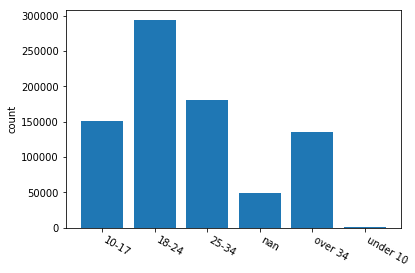

In [37]:
x = stopsearch['Age range']

# Count the number of occurrences of each value in the column
vs,ns = np.unique(x[~pandas.isnull(x)], return_counts=True)  # discard NaN values,
vs,ns = np.unique(x.astype(str), return_counts=True)         # or convert NaN to 'nan'

xs = np.arange(len(vs))                                      # pick x coordinates
plt.bar(xs, ns, align='center')                              # you can also set width=...
plt.xticks(xs, vs, rotation=-30, ha='left')                  # specify and label the x ticks
plt.ylabel('count')
plt.show()

Here's another display, a table showing the most frequent items and their counts. We're using `np.argsort(-ns)` to rearrange the rows in the order of decreasing `ns`, and keeping the first three rows.

In [22]:
pandas.DataFrame({'Age range':vs, 'n':ns}, columns=['Age range','n']).iloc[np.argsort(-ns)[:3]]

,Age range,n
1,18-24,292998
2,25-34,180725
0,10-17,150286


## (b) Investigate numerical columns<span id="numerical"></span>
Numerical columns also have a `describe()` method, which prints out some standard numerical summaries. The only numerical columns in this dataset are latitude and longitude, which it's daft to summarize numerically, but here goes.

In [23]:
stopsearch['Latitude'].describe()

count    495557.000000
mean         52.253553
std           1.099470
min          49.766800
25%          51.469594
50%          51.653199
75%          53.161358
max          55.945400
Name: Latitude, dtype: float64

The obvious way to plot a numerical column is with a histogram. The matplotlib `hist` command doesn't work if there are missing values, so they must be removed first.

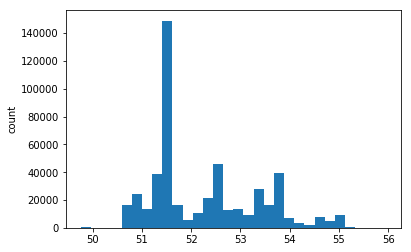

In [24]:
x = stopsearch['Latitude']
plt.hist(x[~pandas.isnull(x)], bins=30)
plt.ylabel('count')
plt.show()

It's sometimes helpful to split a numerical column into categories. Here is a cheap-and-cheerful hack at geocoding. We could achieve the same effect ourselves by fiddling with [`np.digitize`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html), but [`pandas.cut`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html) does everything for us. If we want to cut into categories of roughly equal size, use [`pandas.qcut`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html), or fiddle around with [`np.nanpercentile`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.nanpercentile.html),

In [25]:
region = pandas.cut(stopsearch['Latitude'], bins=[-np.inf, 51.98, 55.27, np.inf], labels=['south','mid/north','scotland'])
ns,vs = np.unique(region.astype(str), return_counts=True)
pandas.DataFrame({'region':vs, 'n':ns})

,n,region
0,mid/north,231792
1,nan,312544
2,scotland,304
3,south,263461


Here's a more intelligent plot of latitude and longitude, a scatter plot, coloured by police force. We iterate through the police forces and draw a scatter plot for each. The scatterplot automatically picks a new colour each time.
(You can also use a mapping library like [gmplot](https://pypi.python.org/pypi/gmplot/1.0.5), which puts nice interactive maps in your Jupyter notebook, using Google map tiles.)

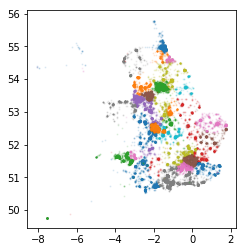

In [55]:
# Plot a sample of points, because there's no point plotting loads of overlaps
df = stopsearch.iloc[np.random.choice(len(stopsearch), size=100000)]

for pf in np.unique(df['police_force']):
    i = df['police_force'] == pf
    plt.scatter(df['Longitude'][i], df['Latitude'][i], s=1, alpha=.1) # control size and alpha

# Set the aspect ratio, based on the UK's average latitude
plt.gca().set_aspect(1/np.cos(54/360*2*np.pi))
plt.show()

## (c) Investigate date/time columns<span id="datetime"></span>
Dates and times are always a nuisance because of timezones, as [xkcd](https://www.xkcd.com/1883/) observes &mdash; and also because of unequal months and leap years and so on, which make it hard work to get axes right in plots. But they're also very common, so here are a few recipes.

<a href="https://www.xkcd.com/1883/"><img src="https://imgs.xkcd.com/comics/supervillain_plan.png" style="height:25em" alt="supervillain timezone woes"></a>

Let's look at some typical values in the `Date` column.

In [26]:
np.random.choice(stopsearch['Date'], 5)

array(['2016-08-26T21:13:00+00:00', '2015-11-15T17:45:00+00:00',
       '2014-12-02T13:10:00+00:00', '2015-11-20T20:00:00+00:00',
       '2015-04-10T13:45:00+00:00'], dtype=object)

To find the time of day of each entry (measured in seconds since midnight), we can just trim the string, split it at colons, and add up the pieces. By using `np.vectorize` we can apply this to the entire vector. 

In [27]:
def as_timeofday(s):
    return sum(int(x)*y for x,y in zip(s[11:19].split(':'), [3600,60,1]))
timeofday = np.vectorize(as_timeofday)(stopsearch['Date'])

Here's a plot, a histogram of the time of day of stop-and-search events. There are two fancy things going on here:

* The plot size is set using [`plt.rc_context`](https://matplotlib.org/users/customizing.html), which lets you control size and many other options.
* [Colours can be specified](https://matplotlib.org/2.0.2/api/colors_api.html) by name, by string for a grey-level, or by an (r,g,b) tuple. 
* Since stop-and-search events happen throughout the night, it's good to show context around midnight. Here we're showing three versions of the histogram in the same plot, and controlling the colour to draw the viewer's attention to a 24-hour window.

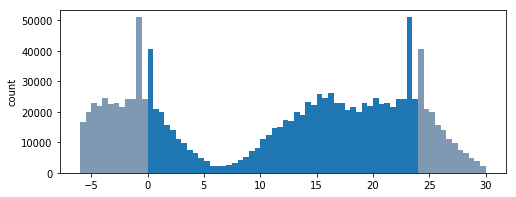

In [28]:
ONEHOUR = 3600
with plt.rc_context({'figure.figsize': (8,3)}):
    plt.hist(timeofday/ONEHOUR, bins=np.linspace(0,24,48+1))
    plt.hist(timeofday[timeofday>18*ONEHOUR]/ONEHOUR-24, bins=np.linspace(-6,0,12+1), color=(.5,.6,.7))
    plt.hist(timeofday[timeofday<6*ONEHOUR]/ONEHOUR+24, bins=np.linspace(24,30,12+1), color=(.5,.6,.7))
plt.ylabel('count')
plt.show()

For the fancy plots that follow, we'll want to work with dates. In my experience, there is only one way to maintain your sanity when working with dates and times: 

* Store dates and datetimes as Unix timestamps, i.e. as seconds since 1970-01-01 00:00:00. 
* If timezones are irrelevant in your dataset, then just pretend everything is all UTC.
* If timezones are relevant in your dataset, then store UTC timestamps, and store an additional column for timezone offset. Do not be tempted to store local time. 

Every language and every library and every database has its own quirks at dealing with datetimes, and it's not worth wasting your time on them, except for learning how to convert to a timestamp.

In [43]:
import datetime, pytz

def as_timestamp(s):
    t = datetime.datetime.strptime(s[:10], '%Y-%m-%d')  # create a naive datetime (with no timezone specified)
    u = t.replace(tzinfo=pytz.UTC)  # set timezone=UTC, otherwise timestamp() is unpredictable
    return int(u.timestamp())

# Create a column with the date, stored as a Unix timestamp
stopsearch['t'] = np.vectorize(as_timestamp)(stopsearch['Date'])

## (d) Clever joins<span id="wrangling"></span>

Let's analyse in detail the number of stop-and-search events per day. The naive method, `stopsearch.groupby('Date').apply(len)`, doesn't make sense: it only aggregates the data there is, so it won't produce a row saying "On date $d$, there were zero events". We need to somehow augment this table to include all possible dates.

Further challenge: this dataset happens to be uneven, with different dates of coverage for different police forces, as this very terse snippet shows. (You'll find yourself writing very powerful one-liners for quick looks at the data. Don't leave them in your finished code, because no one else will be able to understand them. This one is left in as an exercise!)

In [44]:
stopsearch.groupby('police_force')['t'].apply(lambda t: (max(t)-min(t))/(3600*24)).astype(int).reset_index(name='days')[:5]

,police_force,days
0,avon-and-somerset,912
1,bedfordshire,851
2,btp,852
3,cambridgeshire,731
4,cheshire,853


To simplify the problem, let's restrict attention to a single police force. We'll assume that the data covers all incidents from the earliest date to the latest date present. This assumption should be verified by checking the dataset's original documentation &mdash; and remember, "absence of evidence is not evidence of absence".

In [45]:
# Count the number of stop-and-search per day, grouped by outcome, for Cambridgeshire police force
df = stopsearch.loc[stopsearch['police_force'] == 'cambridgeshire', ['t', 'Outcome']]
df['outcome'] = np.where(df['Outcome'] == 'Nothing found - no further action', 'nothing', 'find')
df = df.groupby(['t', 'outcome']).apply(len).reset_index(name='n')

# Build a new dataframe consisting of all possible combinations of 't' and 'find'
# In database language, this is called an 'outer join', and Pandas forces us to do it on a dummy key.
alldays = pandas.DataFrame({'t': range(np.min(df['t']), np.max(df['t']), 3600*24)})
allfind = pandas.DataFrame({'outcome': ['nothing', 'find']})
alldays['k'] = 0
allfind['k'] = 0
allrows = alldays.merge(allfind, on='k', how='outer')[['t','outcome']]

# Merge the dataframe of counts, and the dataframe of all possible rows.
# The 'n' column will be filled with NaN for dates/outcomes not present in df, so turn them to 0.
df = df.merge(allrows, on=['t','outcome'], how='outer')
df['n'] = np.where(pandas.isnull(df['n']), 0, df['n'])

# Reshape the dataframe, using merge, so it has one row per date, and columns for each outcome.
# (This could also be done by converting a suitable indexed array to a wide-form dataframe.) 
x = df.loc[df['outcome'] == 'nothing', ['t','n']]
y = df.loc[df['outcome'] == 'find', ['t','n']]
df = x.merge(y, on='t', suffixes=('_nothing','_find'))

## (c) Fancy plots<span id="plotting"></span>

If you want to save any of these plots, you can right-click on them in the browser and choose "save as", to save a bitmap. To save as PDF,
use `plt.savefig(filename, transparent=True, bbox_inches='tight', pad_inches=0)` and then (on Azure Notebooks) choose the `Data | Download` menu option.

How many stops are there each day by the Cambridgeshire police force, and how any of them result in something being found? The plot below is a _grouped plot_, showing multiple pieces of data. For each piece, we call the usual plot command, and we also provide `label`. This picks a different colour for each piece, and it remembers the association between colours and labels, so that `plt.legend()` can draw the right thing.

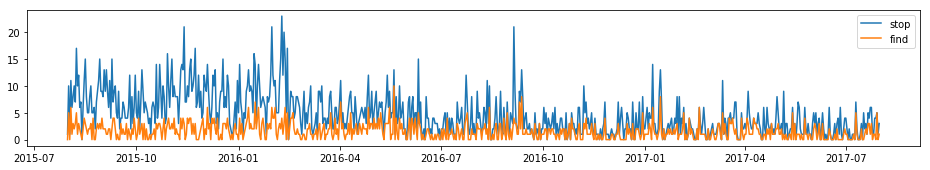

In [46]:
# Sort the data by date, because otherwise the plotted lines could go back and forth across the plot
df = df.iloc[np.argsort(df['t'])]

# Make real date objects, so that matplotlib knows how to format the axis nicely
dates = np.vectorize(datetime.datetime.utcfromtimestamp)(df['t'])

# A grouped plot
with plt.rc_context({'figure.figsize': (16,2.5)}):
    plt.plot(dates, df['n_find']+df['n_nothing'], label='stop')
    plt.plot(dates, df['n_find'], label='find')
plt.legend()
plt.show()

Let's next look at police activity by day of the week, as measured by average number of stop-and-search events, and let's also show the variability as measured by the standard deviation. This involves computing two summaries of the data, combining them, and plotting the result.

In this code I'm doing my own arithmetic on timestamps to get day of week. I find it's easier to do a little bit of arithmetic than to wade through library documentation about datetime utility functions.

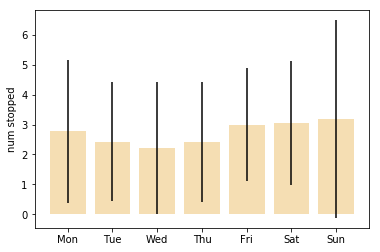

In [47]:
# Compute the weekday for each row.
# Timestamp is measured in seconds since Thu 1970-01-01 00:00, so this computation gives me 0=Mon, 1=Tue, ...
df['weekday'] = (df['t']//(24*3600) - 4) % 7
weekday_names = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

# The previous plot suggests there's a change in policing after 2016-09,
# so let's restrict attention to that range 
df['stops'] = df['n_find'] + df['n_nothing']
t0 = datetime.datetime.strptime('2016-10-01', '%Y-%m-%d').replace(tzinfo=pytz.utc).timestamp()
df2 = df.loc[df['t'] >= t0]

# Compute the two statistics we want to plot: mean and standard deviation of number of stops
x = df2.groupby('weekday')['stops'].apply(np.mean).reset_index(name='mean_stops')
y = df2.groupby('weekday')['stops'].apply(np.std).reset_index(name='sd_stops')
stats = x.merge(y, on='weekday')

# A bar plot with error bars
plt.bar(stats['weekday'], stats['mean_stops'], align='center', facecolor='wheat')
plt.errorbar(stats['weekday'], stats['mean_stops'], yerr=stats['sd_stops'], linestyle='None', ecolor='black')
plt.xticks(range(0,7), weekday_names)
plt.ylabel('num stopped')
plt.show()

Our final plot is called a _facet plot_ or a _panel plot_ or a _small multiples_ plot. [According to the plotting guru Edward Tufte](https://en.wikipedia.org/wiki/Small_multiple),

> At the heart of quantitative reasoning is a single question: Compared to what? Small multiple designs, multivariate and data bountiful,
> answer directly by visually enforcing comparisons of changes, of the differences among objects, of the scope of alternatives. For a wide
> range of problems in data presentation, small multiples are the best design solution.

Let's plot a histogram for each day of the week, showing the distribution of the number of stops made.

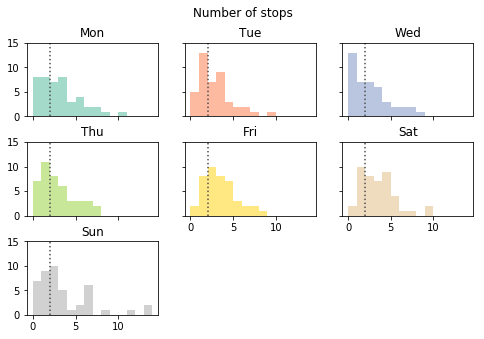

In [34]:
with plt.rc_context({'figure.figsize': (8,5), 'figure.subplot.hspace': 0.35}):

    # Get a colour map with 7 pretty colours: see https://matplotlib.org/users/colormaps.html
    cols = plt.get_cmap('Set2', 7)

    fig = plt.figure()
    for i, weekday in enumerate(range(7)):
        # Create a new facet
        ax = fig.add_subplot(3, 3, i+1)

        # Plot the histogram. Force the x-axis bins and y-axis range to be identical in each facet
        ax.hist(df2.loc[df2['weekday']==weekday, 'stops'], alpha=.6, facecolor=cols(i), bins=range(15))
        ax.set_ylim(0,15)

        # Some annotations.
        # Suppress the tick labels, except on the outside facets.
        ax.axvline(x=np.median(df2['stops']), linestyle='dotted', color='.3')
        ax.set_title(weekday_names[weekday])
        if i < 4: ax.set_xticklabels([])
        if (i % 3) != 0: ax.set_yticklabels([])

fig.suptitle('Number of stops')
plt.show()

There are two ways to generate a facet plot.

* When we want facets for one variable, as is the case here for the variable `weekday`, use [`ax = fig.add_subplot(nrows, ncols, i)`](https://matplotlib.org/api/figure_api.html#matplotlib.figure.Figure.add_subplot) to add facets one by one. This creates a new facet in position `i`, from a `nrows * ncols` grid arrangement.
* When we want facets for two variables, use [`fig,ax_array = plt.subplots(nrows,ncols)`](https://matplotlib.org/examples/pylab_examples/subplots_demo.html), as in
[these demos](https://matplotlib.org/examples/pylab_examples/subplots_demo.html), to create a full grid of facets in one go.

Previously we have used commands like `plt.hist()` to draw histograms, but this code uses `ax.hist()` where `ax` is an `Axes` object. All the matplotlib `plt.*` plotting routines are actually [`Axes` methods](https://matplotlib.org/api/axes_api.html), and the `plt.*` names are just aliases. 
For a plot with a single facet, you can use either style.